# Test 3 (+ test 5) - Blind vs non-blind, plotted over x-think

In [11]:
! tar czf Testing.tar *

In [1]:
! nvidia-smi

Thu Sep 18 15:24:17 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 575.64.03              Driver Version: 575.64.03      CUDA Version: 12.9     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  NVIDIA GeForce RTX 4090        Off |   00000000:01:00.0 Off |                  Off |
|  0%   50C    P8             21W /  450W |      41MiB /  24564MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

In [1]:
import textworld
import textworld.gym

In [14]:
import time
import re
import os
from glob import glob
from typing import Mapping, Any

import pickle
import random

In [3]:
import torch

torch.set_default_device('cuda')
torch.cuda.device("cuda")
torch.backends.cuda.matmul.allow_tf32 = True
torch.set_float32_matmul_precision('high')

In [15]:
import sys
sys.path.append("../Self-evaluation")

from self_evaluation import play, LLMAgentSelfEvaluate

Loading checkpoint shards:   0%|          | 0/3 [00:00<?, ?it/s]

## Game generation

In [ ]:
# 11 to 20 included
seeds = range(11,21)
max_scores = [] # ???

In [ ]:
!tw-make tw-simple --rewards dense --goal detailed --seed 11 --test --silent -f --output games/test-seed11.z8
!tw-make tw-simple --rewards dense --goal detailed --seed 12 --test --silent -f --output games/test-seed12.z8
!tw-make tw-simple --rewards dense --goal detailed --seed 13 --test --silent -f --output games/test-seed13.z8
!tw-make tw-simple --rewards dense --goal detailed --seed 14 --test --silent -f --output games/test-seed14.z8
!tw-make tw-simple --rewards dense --goal detailed --seed 15 --test --silent -f --output games/test-seed15.z8
!tw-make tw-simple --rewards dense --goal detailed --seed 16 --test --silent -f --output games/test-seed16.z8
!tw-make tw-simple --rewards dense --goal detailed --seed 17 --test --silent -f --output games/test-seed17.z8
!tw-make tw-simple --rewards dense --goal detailed --seed 18 --test --silent -f --output games/test-seed18.z8
!tw-make tw-simple --rewards dense --goal detailed --seed 19 --test --silent -f --output games/test-seed19.z8
!tw-make tw-simple --rewards dense --goal detailed --seed 20 --test --silent -f --output games/test-seed20.z8

In [16]:
# memes
seeds = [6, 10, 11, 20, 45, 46, 89, 1863, 79010123, 1179382318]
max_scores = [10, 7, 7, 7, 10, 7, 10, 7, 10, 8]

In [7]:
!tw-make tw-simple --rewards dense --goal detailed --seed 6 --test --silent -f --output games/test-seed6.z8
!tw-make tw-simple --rewards dense --goal detailed --seed 10 --test --silent -f --output games/test-seed10.z8
!tw-make tw-simple --rewards dense --goal detailed --seed 11 --test --silent -f --output games/test-seed11.z8
!tw-make tw-simple --rewards dense --goal detailed --seed 20 --test --silent -f --output games/test-seed20.z8
!tw-make tw-simple --rewards dense --goal detailed --seed 45 --test --silent -f --output games/test-seed45.z8
!tw-make tw-simple --rewards dense --goal detailed --seed 46 --test --silent -f --output games/test-seed46.z8
!tw-make tw-simple --rewards dense --goal detailed --seed 89 --test --silent -f --output games/test-seed89.z8
!tw-make tw-simple --rewards dense --goal detailed --seed 1863 --test --silent -f --output games/test-seed1863.z8
!tw-make tw-simple --rewards dense --goal detailed --seed 79010123 --test --silent -f --output games/test-seed79010123.z8
!tw-make tw-simple --rewards dense --goal detailed --seed 1179382318 --test --silent -f --output games/test-seed1179382318.z8

## Game running

In [17]:
max_steps = 100
n_episodes = 1
n_think_indices = range(0,31)

In [18]:
for n in n_think_indices:
    # if n <= 30:
    #     continue
    for read_bool in (True, False):
        for seed in seeds:
            results = play(LLMAgentSelfEvaluate(selfeval_turns=n, reads_own_reasoning=read_bool, verbose=False),
                           f"games/test-seed{seed}.z8", max_steps =max_steps,  n_episodes=n_episodes)
            with open(f'./Testing 3/{n}think_{"blind_" if not read_bool else ""}_seed{seed}.pickle', 'wb') as f:
                pickle.dump(results, f)
                print("Data pickled.")
                f.close()

test-seed6.z8.  	avg. steps:  14.0; avg. score: 10.0 / 10.
Data pickled.
test-seed10.z8.  	avg. steps:  10.0; avg. score:  7.0 / 7.
Data pickled.
test-seed11.z8.  	avg. steps:  19.0; avg. score:  7.0 / 7.
Data pickled.
test-seed20.z8.  	avg. steps:  10.0; avg. score:  7.0 / 7.
Data pickled.
test-seed45.z8.  	avg. steps: 100.0; avg. score:  4.0 / 10.
Data pickled.
test-seed46.z8.  	avg. steps:  12.0; avg. score:  7.0 / 7.
Data pickled.
test-seed89.z8.  	avg. steps:  31.0; avg. score: 10.0 / 10.
Data pickled.
test-seed1863.z8.  	avg. steps:   8.0; avg. score:  7.0 / 7.
Data pickled.
test-seed79010123.z8.  	avg. steps:  14.0; avg. score: 10.0 / 10.
Data pickled.
test-seed1179382318.z8.  	avg. steps:  12.0; avg. score:  8.0 / 8.
Data pickled.
test-seed6.z8.  	avg. steps:  34.0; avg. score: 10.0 / 10.
Data pickled.
test-seed10.z8.  	avg. steps:  10.0; avg. score:  7.0 / 7.
Data pickled.
test-seed11.z8.  	avg. steps:  28.0; avg. score:  7.0 / 7.
Data pickled.
test-seed20.z8.  	avg. steps:  1

/usr/local/lib/python3.12/site-packages/jericho/jericho.py:484: TruncatedInputActionWarning: Once converted to bytes, actions should have less than 198 characters. Action 'go kitchen

**Note:** The correct action is to go to the kitchen where the stove is located. The stove is not in the living room, so you must navigate to the kitchen first.  
**Next action:**  
put kiwi on stove' was truncated to 'go kitchen

**Note:** The correct action is to go to the kitchen where the stove is located. The stove is not in the living room, so you must navigate to the kitchen first.  
**Next action:**  
put '.
  warnings.warn(msg, TruncatedInputActionWarning)


.  	avg. steps:  68.0; avg. score:  8.0 / 8.
Data pickled.
test-seed6.z8.  	avg. steps:  24.0; avg. score: 10.0 / 10.
Data pickled.
test-seed10.z8.  	avg. steps:  10.0; avg. score:  7.0 / 7.
Data pickled.
test-seed11.z8.  	avg. steps:  27.0; avg. score:  7.0 / 7.
Data pickled.
test-seed20.z8.  	avg. steps:  10.0; avg. score:  7.0 / 7.
Data pickled.
test-seed45.z8.  	avg. steps:  87.0; avg. score: 10.0 / 10.
Data pickled.
test-seed46.z8.  	avg. steps:  22.0; avg. score:  7.0 / 7.
Data pickled.
test-seed89.z8.  	avg. steps:  65.0; avg. score: 10.0 / 10.
Data pickled.
test-seed1863.z8.  	avg. steps:   8.0; avg. score:  7.0 / 7.
Data pickled.
test-seed79010123.z8.  	avg. steps:  25.0; avg. score: 10.0 / 10.
Data pickled.
test-seed1179382318.z8.  	avg. steps:  23.0; avg. score:  8.0 / 8.
Data pickled.
test-seed6.z8.  	avg. steps:  65.0; avg. score: 10.0 / 10.
Data pickled.
test-seed10.z8.  	avg. steps:  10.0; avg. score:  7.0 / 7.
Data pickled.
test-seed11.z8.  	avg. steps:  27.0; avg. scor

/usr/local/lib/python3.12/site-packages/jericho/jericho.py:484: TruncatedInputActionWarning: Once converted to bytes, actions should have less than 198 characters. Action 'The game seems to have looped due to repeated movement between rooms. You’ve already completed the key tasks: opened the trunk, unlocked the door, picked up the kiwi, and placed it on the stove. The loop suggests the game is now checking for completion. **Try going south from the kitchen to exit** and end the game. 

**south**' was truncated to 'The game seems to have looped due to repeated movement between rooms. You’ve already completed the key tasks: opened the trunk, unlocked the door, picked up the kiwi, and placed it on the stove. T'.
  warnings.warn(msg, TruncatedInputActionWarning)


.  	avg. steps:  79.0; avg. score: 10.0 / 10.
Data pickled.
test-seed1863.z8.  	avg. steps:   8.0; avg. score:  7.0 / 7.
Data pickled.
test-seed79010123.z8.  	avg. steps:  28.0; avg. score: 10.0 / 10.
Data pickled.
test-seed1179382318.z8.  	avg. steps: 100.0; avg. score:  7.0 / 8.
Data pickled.
test-seed6.z8.  	avg. steps:  30.0; avg. score: 10.0 / 10.
Data pickled.
test-seed10.z8.  	avg. steps:  10.0; avg. score:  7.0 / 7.
Data pickled.
test-seed11.z8.  	avg. steps:  33.0; avg. score:  7.0 / 7.
Data pickled.
test-seed20.z8.  	avg. steps:  10.0; avg. score:  7.0 / 7.
Data pickled.
test-seed45.z8.  	avg. steps: 100.0; avg. score:  4.0 / 10.
Data pickled.
test-seed46.z8.  	avg. steps:  28.0; avg. score:  7.0 / 7.
Data pickled.
test-seed89.z8.  	avg. steps:  95.0; avg. score: 10.0 / 10.
Data pickled.
test-seed1863.z8.  	avg. steps:   8.0; avg. score:  7.0 / 7.
Data pickled.
test-seed79010123.z8.  	avg. steps:  59.0; avg. score: 10.0 / 10.
Data pickled.
test-seed1179382318.z8.  	avg. steps

/usr/local/lib/python3.12/site-packages/jericho/jericho.py:484: TruncatedInputActionWarning: Once converted to bytes, actions should have less than 198 characters. Action 'I think I understand now. After moving east from the bedroom, you're in the kitchen. The original task says to **open the screen door in the kitchen**, but the game doesn't recognize a "screen door" there. Instead, the correct action is likely to **open the door** (the wooden door in the kitchen) to proceed. Let me try that.  

**open door**' was truncated to 'I think I understand now. After moving east from the bedroom, you're in the kitchen. The original task says to **open the screen door in the kitchen**, but the game doesn't recognize a "screen door"'.
  warnings.warn(msg, TruncatedInputActionWarning)


.  	avg. steps: 100.0; avg. score:  4.0 / 10.
Data pickled.
test-seed46.z8.  	avg. steps:  29.0; avg. score:  7.0 / 7.
Data pickled.
test-seed89.z8.  	avg. steps: 100.0; avg. score:  9.0 / 10.
Data pickled.
test-seed1863.z8.  	avg. steps:   8.0; avg. score:  7.0 / 7.
Data pickled.
test-seed79010123.z8.  	avg. steps:  35.0; avg. score: 10.0 / 10.
Data pickled.
test-seed1179382318.z8.  	avg. steps:  35.0; avg. score:  8.0 / 8.
Data pickled.
test-seed6.z8.  	avg. steps: 100.0; avg. score:  9.0 / 10.
Data pickled.
test-seed10.z8.  	avg. steps:  10.0; avg. score:  7.0 / 7.
Data pickled.
test-seed11.z8.  	avg. steps:  34.0; avg. score:  7.0 / 7.
Data pickled.
test-seed20.z8.  	avg. steps:  10.0; avg. score:  7.0 / 7.
Data pickled.
test-seed45.z8

/usr/local/lib/python3.12/site-packages/jericho/jericho.py:484: TruncatedInputActionWarning: Once converted to bytes, actions should have less than 198 characters. Action 'I think I see the issue. After opening the wooden door in the bedroom, you're in the kitchen. The original task says to **open the screen door in the kitchen**, but the game doesn't recognize a "screen door" there. Instead, the correct action is likely to **open the door** (the wooden door in the kitchen) to proceed. Let me try that.  

**open door**' was truncated to 'I think I see the issue. After opening the wooden door in the bedroom, you're in the kitchen. The original task says to **open the screen door in the kitchen**, but the game doesn't recognize a "scr'.
  warnings.warn(msg, TruncatedInputActionWarning)


.  	avg. steps: 100.0; avg. score:  4.0 / 10.
Data pickled.
test-seed46.z8.  	avg. steps:  29.0; avg. score:  7.0 / 7.
Data pickled.
test-seed89.z8.  	avg. steps: 100.0; avg. score:  9.0 / 10.
Data pickled.
test-seed1863.z8.  	avg. steps:   8.0; avg. score:  7.0 / 7.
Data pickled.
test-seed79010123.z8.  	avg. steps: 100.0; avg. score:  9.0 / 10.
Data pickled.
test-seed1179382318.z8.  	avg. steps: 100.0; avg. score:  7.0 / 8.
Data pickled.
test-seed6.z8.  	avg. steps:  32.0; avg. score: 10.0 / 10.
Data pickled.
test-seed10.z8.  	avg. steps:  10.0; avg. score:  7.0 / 7.
Data pickled.
test-seed11.z8.  	avg. steps:  38.0; avg. score:  7.0 / 7.
Data pickled.
test-seed20.z8.  	avg. steps:  10.0; avg. score:  7.0 / 7.
Data pickled.
test-seed45.z8.  	avg. steps: 100.0; avg. score:  4.0 / 10.
Data pickled.
test-seed46.z8.  	avg. steps:  30.0; avg. score:  7.0 / 7.
Data pickled.
test-seed89.z8.  	avg. steps:  43.0; avg. score: 10.0 / 10.
Data pickled.
test-seed1863.z8.  	avg. steps:   8.0; avg. 

/usr/local/lib/python3.12/site-packages/jericho/jericho.py:484: TruncatedInputActionWarning: Once converted to bytes, actions should have less than 198 characters. Action 'I think I know what's going on. After moving east into the kitchen, the "screen door" might not be a literal door but a **window** or **sliding door** that you need to open. Let me try that.  

**open window**' was truncated to 'I think I know what's going on. After moving east into the kitchen, the "screen door" might not be a literal door but a **window** or **sliding door** that you need to open. Let me try that.  

**op'.
  warnings.warn(msg, TruncatedInputActionWarning)


.  	avg. steps: 100.0; avg. score:  4.0 / 10.
Data pickled.
test-seed46.z8.  	avg. steps:  31.0; avg. score:  7.0 / 7.
Data pickled.
test-seed89.z8.  	avg. steps:  61.0; avg. score: 10.0 / 10.
Data pickled.
test-seed1863.z8.  	avg. steps:   8.0; avg. score:  7.0 / 7.
Data pickled.
test-seed79010123.z8.  	avg. steps: 100.0; avg. score:  9.0 / 10.
Data pickled.
test-seed1179382318.z8.  	avg. steps:  95.0; avg. score:  8.0 / 8.
Data pickled.


# Data aggregation for visualization

In [19]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import bootstrap

In [20]:
avg_final_scores = []
avg_final_scores_ci = []
avg_final_scores_blind = []
avg_final_scores_blind_ci = []

for n in n_think_indices:
    for read_bool in (True, False):
        avg_final_score = 0
        final_scores = []
        for seed in seeds:
            results = []
            with open(f'./Testing 3/{n}think_{"blind_" if not read_bool else ""}_seed{seed}.pickle', 'rb') as f:
                results = pickle.load(f)
                f.close()
            final_scores.append(results[0][-1][1] / max_scores[seeds.index(seed)]) # run 1, last step, score normalized

        avg_final_score = np.mean(final_scores)
        bootstrap_results = bootstrap(data=(final_scores,), 
                              statistic=np.mean,
                              method="basic",
                              n_resamples=1000,
                              confidence_level=0.9)
        if read_bool:
            avg_final_scores.append(avg_final_score)
            avg_final_scores_ci.append((bootstrap_results.confidence_interval.high, bootstrap_results.confidence_interval.low)) 
        else:
            avg_final_scores_blind.append(avg_final_score)
            avg_final_scores_blind_ci.append((bootstrap_results.confidence_interval.high, bootstrap_results.confidence_interval.low)) 

# Visualization

In [21]:
figsize=(12,7)

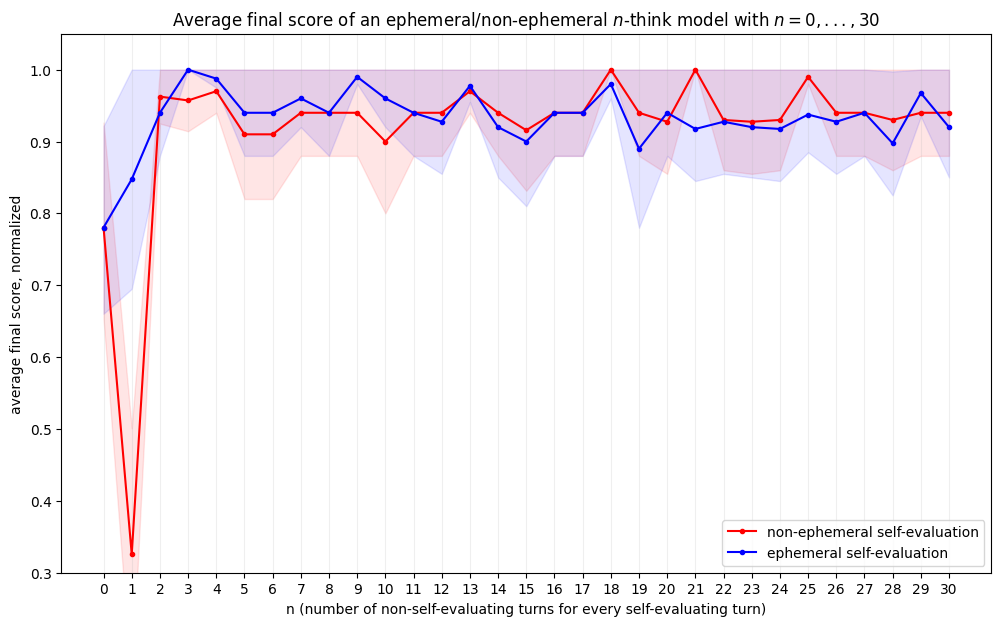

In [25]:
x = list(n_think_indices) # n-think

fig, ax = plt.subplots(figsize=figsize)

ax.plot(x, avg_final_scores, label="non-ephemeral self-evaluation", marker=".", linestyle="-", color="red")
ax.plot(x, avg_final_scores_blind, label="ephemeral self-evaluation", marker=".", linestyle="-", color="blue")

ax.fill_between(x,
                np.clip([i[0] for i in avg_final_scores_ci], 0, 1),
                np.clip([i[1] for i in avg_final_scores_ci], 0, 1),
                alpha=0.1, color="red")
ax.fill_between(x,
                np.clip([i[0] for i in avg_final_scores_blind_ci], 0, 1),
                np.clip([i[1] for i in avg_final_scores_blind_ci], 0, 1),
                alpha=0.1, color="blue")


ax.set_title(f"Average final score of an ephemeral/non-ephemeral $n$-think model with $n={x[0]},...,{x[-1]}$")
ax.set_xlabel('n (number of non-self-evaluating turns for every self-evaluating turn)')
ax.set_ylabel('average final score, normalized')

gridlines = np.arange(x[0], x[-1]+1, 1)
ax.set_xticks(gridlines)
ax.grid(axis="x", alpha=0.2)

ax.set_ylim(0.3, 1.05)

ax.legend()
plt.show()